second pass, using embedding generated only from target transcripts 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, auc
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.utils import to_categorical
tf.test.is_gpu_available()
os.chdir('/data/swamyvs/pacbio_testing/')

/data/swamyvs/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:

class SimpleDataObj:
    def __init__(self, x_mat_file, labels_file,kmer_size, one_label, zero_label, y_format='tf'):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'] )
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        Y_vec=np.asarray(X_df_labeled['target_label'])
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec
        
        X_train, self.X_val, Y_train_labs, Y_val_labs= train_test_split(X_data,labs,test_size=.2, random_state=42, stratify=Y_vec)
        self.X_train, self.X_test, Y_train_labs, Y_test_labs=train_test_split(X_train,Y_train_labs,test_size=.2, 
                                                                                  random_state=42,stratify=Y_train_labs['target_label'])

        if y_format == 'tf':
            self.Y_val=to_categorical(Y_val_labs['target_label'])
            self.Y_train=to_categorical(Y_train_labs['target_label'])
            self.Y_test=to_categorical(Y_test_labs['target_label'])
        else:
            self.Y_val=np.asarray(Y_val_labs['target_label'])
            self.Y_train=np.asarray(Y_train_labs['target_label'])
            self.Y_test=np.asarray(Y_test_labs['target_label'])
            
        self.Y_val_labs=Y_val_labs[['transcript_id','intersection_case']] 
        self.Y_train_labs=Y_train_labs[['transcript_id','intersection_case']]
        self.Y_test_labs=Y_test_labs[['transcript_id','intersection_case']]
            
        self.y_format=y_format
        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')



def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def PR_plot(Y_test, Y_prob):
    pre, rec, thresholds = precision_recall_curve(Y_test, Y_prob)
    AUC = auc(rec, pre)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()  
def skl_model_results(obj, model):
    X_train=obj.X_train
    Y_train=obj.Y_train
    X_test=obj.X_test
    Y_test=obj.Y_test
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    labs=model.classes_
    print('confusion matrix\n\n')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), index=labs, columns=labs))
    print('\n\nclassification report\n\n')
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    ROC_plot(Y_test , Y_prob)
    PR_plot(Y_test,Y_prob)
    return(model)

In [3]:
dat=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'transcript',
                  'not_transcript',
                  'sk'
                 )

In [4]:
rf_model=RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=32)
rf_model.fit(dat.X_train[1:100], dat.Y_train[1:100])
labs=['not_transcript', 'transcript']
#pd.DataFrame(confusion_matrix(dat.Y_test[1:100], rf_model.predict(dat.X_test)[1:100]), index=labs, columns=labs)
k=classification_report(y_pred=rf_model.predict(dat.X_test)[1:100],y_true=dat.Y_test[1:100], output_dict=True )

In [5]:
k['0']

{'precision': 0.813953488372093,
 'recall': 0.9090909090909091,
 'f1-score': 0.8588957055214723,
 'support': 77}

In [4]:
rf_model=RandomForestClassifier(n_estimators=100, random_state=32, n_jobs=32)
rf_model.fit(dat.X_train, dat.Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

confusion matrix


       0     1
0  56535  7911
1  24693  7031


classification report


              precision    recall  f1-score   support

           0       0.70      0.88      0.78     64446
           1       0.47      0.22      0.30     31724

    accuracy                           0.66     96170
   macro avg       0.58      0.55      0.54     96170
weighted avg       0.62      0.66      0.62     96170



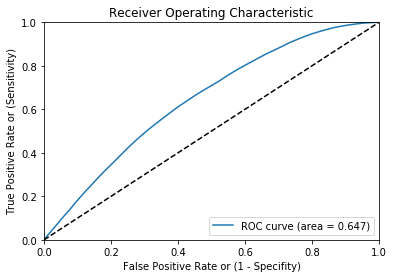

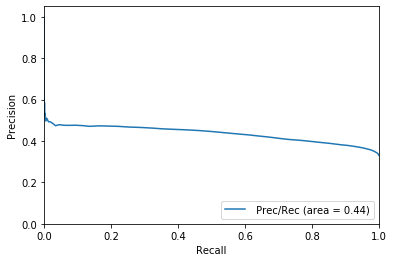

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=32, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [5]:
skl_model_results(dat, rf_model)


In [11]:
from xgboost import XGBClassifier
xgb_model=XGBClassifier(n_jobs=32, random_state=32)
xgb_model.fit(dat.X_train, dat.Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=32,
              nthread=None, objective='binary:logistic', random_state=32,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

confusion matrix


       0     1
0  60317  4129
1  26693  5031


classification report


              precision    recall  f1-score   support

           0       0.69      0.94      0.80     64446
           1       0.55      0.16      0.25     31724

    accuracy                           0.68     96170
   macro avg       0.62      0.55      0.52     96170
weighted avg       0.65      0.68      0.61     96170



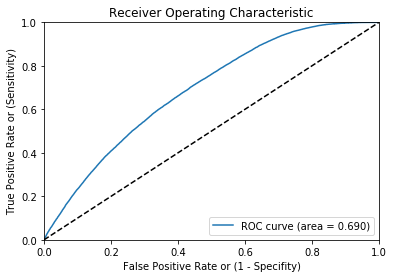

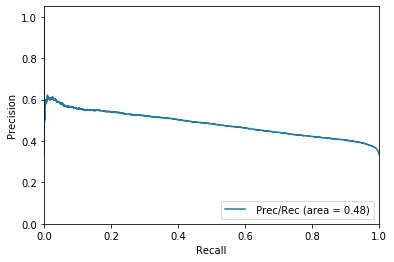

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=32,
              nthread=None, objective='binary:logistic', random_state=32,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
skl_model_results(dat, xgb_model)

In [4]:
dat_tf=SimpleDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                  'transcript',
                  'not_transcript',
                  'tf'
                 )

In [5]:
MAX_TRAIN_SIZE=len(dat_tf.X_train) +1
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]



def plot_metrics(history):
    metrics =  ['loss', 'auc', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,1,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.7,1])
        else:
            plt.ylim([0,1])

        plt.legend()
def train_dense_model(obj):
    model=keras.Sequential()
    model.add(keras.layers.Dense(300,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(200,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(100,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(10,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=200, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)
def run_all(model, data, plot_title):
    history, model = model(data)
    metrics =  ['loss', 'auc', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.7,1])
        else:
            plt.ylim([0,1])

        plt.legend()
    pred=[p[1] for p in  model.predict(data.X_test)]
    pred_class = np.int64([p > .5 for p in pred])
    true_class=[i[1] for i in data.Y_test]
    
    fpr, tpr, thresholds=roc_curve(true_class, pred)
    AUC=roc_auc_score(true_class, pred)
    # Plot ROC curve
    plt.subplot(2,3,4)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
   
    pre, rec, thresholds = precision_recall_curve(true_class, pred)
    AUC = auc(rec, pre)
    plt.subplot(2,3,5)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( AUC))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall plot')
    plt.legend(loc="lower right")
    
    
    plt.suptitle(plot_title)
    plt.show()
    labs=[data.zero_label, data.one_label] 
    print(pd.DataFrame(confusion_matrix(true_class, pred_class), index=labs, columns=labs))
    print(classification_report(pred_class,true_class))
    return history, model 

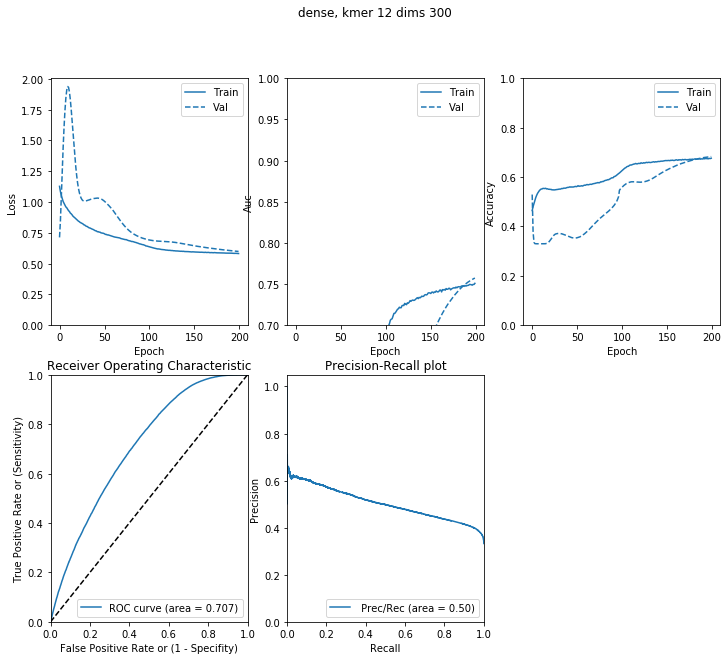

                not_transcript  transcript
not_transcript           53676       10770
transcript               19806       11918
              precision    recall  f1-score   support

           0       0.83      0.73      0.78     73482
           1       0.38      0.53      0.44     22688

    accuracy                           0.68     96170
   macro avg       0.60      0.63      0.61     96170
weighted avg       0.73      0.68      0.70     96170



In [15]:
dense_hist, dense_model= run_all(train_dense_model, dat_tf, 'dense, kmer 12 dims 300')

In [15]:
class RnnDataObj:
    def __init__(self, x_mat_file, labels_file,kmer_size,block_size, one_label, zero_label):
        positive_cases=['all', 'stringtie-pacbio', 'scallop-pacbio']
        X_df=pd.read_csv(x_mat_file,names=['transcript_id']+ list(range(kmer_size)))
        labs=(pd
            .read_csv(labels_file, sep= '\t', names=['transcript_id', 'intersection_case'] )
            .assign(target_label=lambda x: np.where(x['intersection_case'].isin(positive_cases),1,0 )) )
        X_df_labeled=pd.merge(left=labs, right=X_df, left_on='transcript_id', right_on='transcript_id')
        X_data=np.asarray(X_df_labeled.iloc[:,3:])#drop the first 3 columns
        
        assert X_data.shape[1] % block_size == 0
        block_dim=int(X_data.shape[1] / block_size)
        X_data=np.asarray( [vec.reshape(block_size, block_dim) for vec in X_data])
        Y_vec=np.asarray(X_df_labeled['target_label'])
        
        self.Y_origin=X_df_labeled.iloc[:,:3]
        self.vec_y=Y_vec

        X_train, self.X_val, Y_train_labs, Y_val_labs= train_test_split(X_data,labs,test_size=.2, random_state=42, stratify=Y_vec)
        self.Y_val=to_categorical(Y_val_labs['target_label'])
        self.Y_val_labs=Y_val_labs[['transcript_id','intersection_case']]
        self.X_train, self.X_test, Y_train_labs, Y_test_labs=train_test_split(X_train,Y_train_labs,test_size=.2, 
                                                                              random_state=42,stratify=Y_train_labs['target_label'])
        self.Y_train=to_categorical(Y_train_labs['target_label'])
        self.Y_train_labs=Y_train_labs[['transcript_id','intersection_case']]
        self.Y_test=to_categorical(Y_test_labs['target_label'])
        self.Y_test_labs=Y_test_labs[['transcript_id','intersection_case']]

        self.one_label=one_label
        self.zero_label=zero_label
    def summary(self):
        tr_len=len(self.X_train)
        ts_len=len(self.X_test)
        v_len= len(self.X_val)
        print(f'Training size: {tr_len}\nvalidation size: {v_len}\ntesting size: {ts_len}')
        print(f'{self.one_label} count: {np.count_nonzero(self.vec_y == 1)}\n{self.zero_label} count : {np.count_nonzero(self.vec_y == 0)}')
        
        
        
        
def LSTM_dense_model(obj, batch_n=128, nepochs=300):
    NUM_UNITS=150
    MAX_TRAIN_SIZE=int(obj.X_train.shape[0] / batch_n)
    DIM=obj.X_train.shape[1:]
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=DIM))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=NUM_UNITS)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(150,activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(50,  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=nepochs, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)


def LSTMX2_dense_model(obj, batch_n=128, nepochs=300):
    NUM_UNITS=128
    MAX_TRAIN_SIZE=int(obj.X_train.shape[0] / batch_n)
    DIM=obj.X_train.shape[1:]
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=DIM))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=NUM_UNITS,return_sequences=True)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=int(NUM_UNITS/2) ) ) )
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense( int(NUM_UNITS/2),  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(int(NUM_UNITS/4),  activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(2, activation='softmax'))
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)
    history=model.fit(obj.X_train, obj.Y_train, epochs=nepochs, batch_size= MAX_TRAIN_SIZE, 
                    validation_data=(obj.X_val, obj.Y_val), verbose=0)
    #model.predict()
    return(history, model)


In [16]:
rnn_dat=RnnDataObj('data/embedded_model_data/all_RPE_loose_kmers_12_dims-300.csv.gz', 
                  'data/gtf_info/all_RPE_loose_target_tx.tsv',
                   300,
                   10,
                  'transcript',
                  'not_transcript',
                 )

In [17]:
rnn_dat.X_train.shape

(384678, 10, 30)

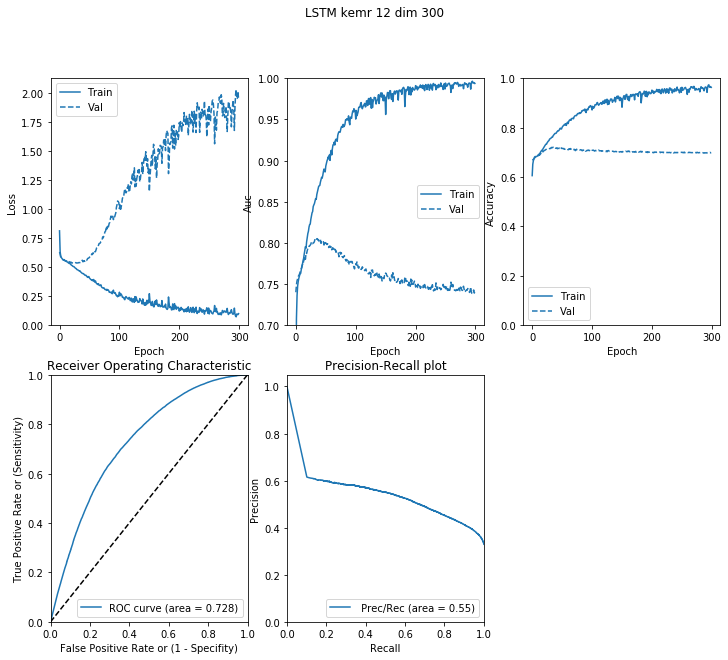

                not_transcript  transcript
not_transcript           50810       13636
transcript               15283       16441
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     66093
           1       0.52      0.55      0.53     30077

    accuracy                           0.70     96170
   macro avg       0.65      0.66      0.66     96170
weighted avg       0.70      0.70      0.70     96170



In [8]:
rnn_hist, rnn_model=run_all(LSTM_dense_model, rnn_dat, 'LSTM kemr 12 dim 300')

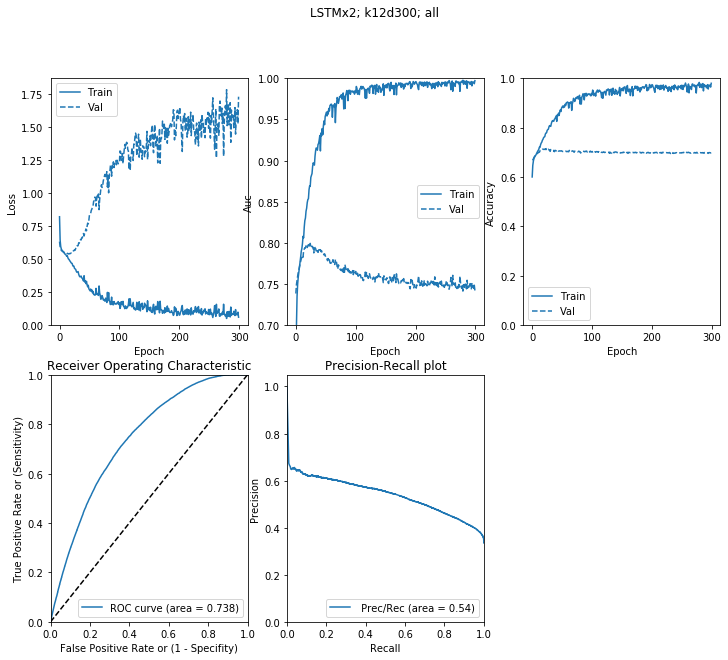

                not_transcript  transcript
not_transcript           50535       13911
transcript               14929       16795
              precision    recall  f1-score   support

           0       0.78      0.77      0.78     65464
           1       0.53      0.55      0.54     30706

    accuracy                           0.70     96170
   macro avg       0.66      0.66      0.66     96170
weighted avg       0.70      0.70      0.70     96170



In [24]:
rnnx2_hist, rnnx2_model = run_all(LSTMX2_dense_model, rnn_dat, 'LSTMx2; k12d300; all')

In [13]:
k=rnn_dat.Y_origin

In [20]:
k.columns

Index(['transcript_id', 'intersection_case', 'target_label'], dtype='object')

In [21]:
k[['transcript_id', 'intersection_case']]

,transcript_id,intersection_case
0,TCONS_00000001,stringtie
1,TCONS_00000006,all
2,TCONS_00000007,all
3,TCONS_00000008,stringtie-scallop
4,TCONS_00000009,stringtie-pacbio
...,...,...
601056,TCONS_01711034,scallop
601057,TCONS_01711035,scallop-pacbio
601058,TCONS_01711036,scallop-pacbio
601059,TCONS_01711037,scallop


In [22]:
def extract_intersection_cases(model, data):
    pred=np.asarray([p[1] for p in  model.predict(data.X_test)])
    pred_class = np.int64([p > .5 for p in pred])
    true_class=np.asarray([i[1] for i in data.Y_test])
    pred_cor= true_class == pred_class
    pred_fal= true_class != pred_class
    pred_true_probs=pred[pred_cor]
    pred_true_labels = data.Y_test_labs['intersection_case'][pred_cor]
    pred_false_probs = pred[pred_fal]
    pred_false_labels = data.Y_test_labs['intersection_case'][pred_fal]
    pred_true_txid = data.Y_test_labs['transcript_id'][pred_cor]
    pred_false_txid = data.Y_test_labs['transcript_id'][pred_fal]
    return pd.DataFrame({'probs':pred_true_probs, 'labs':pred_true_labels, 'transcript_id': pred_true_txid}, index=None), \
            pd.DataFrame({'probs':pred_false_probs, 'labs':pred_false_labels, 'transcript_id': pred_false_txid}, index=None)

def extract_intersection_cases_skl(model, data):
    pred_class=model.predict(data.X_test)
    pred=model.predict_proba(data.X_test)[:,1]
    true_class=np.asarray(data.Y_test)
    pred_cor= true_class == pred_class
    pred_fal= true_class != pred_class
    pred_true_probs=pred[pred_cor]
    pred_true_labels = data.Y_test_labs['intersection_case'][pred_cor]
    pred_false_probs = pred[pred_fal]
    pred_false_labels = data.Y_test_labs['intersection_case'][pred_fal]
    pred_true_txid = data.Y_test_labs['transcript_id'][pred_cor]
    pred_false_txid = data.Y_test_labs['transcript_id'][pred_fal]
    return pd.DataFrame({'probs':pred_true_probs, 'labs':pred_true_labels, 'transcript_id': pred_true_txid}, index=None), \
            pd.DataFrame({'probs':pred_false_probs, 'labs':pred_false_labels, 'transcript_id': pred_false_txid}, index=None)



In [ ]:
right, wrong=extract_intersection_cases(rnn_model, rnn_dat)
right.to_csv('testing/rnn_k12d300_right.csv')
wrong.to_csv('testing/rnn_k12d300_wrong.csv')

In [ ]:
right, wrong=extract_intersection_cases(dense_model, dat_tf)
right.to_csv('testing/dense_k12d300_right.csv')
wrong.to_csv('testing/dens_k12d300_wrong.csv')

In [ ]:
right, wrong=extract_intersection_cases_skl(rf_model, dat)
right.to_csv('testing/rf_k12d300_right.csv')
wrong.to_csv('testing/rf_k12d300_wrong.csv')

In [26]:
import pathlib

In [28]:
pathlib.Path('/tmp/sub1').mkdir(exist_ok=True)

FileExistsError: [Errno 17] File exists: '/tmp/sub1'

In [6]:
np.int64(1) == int(1)

True

In [7]:
import glob

In [12]:
glob.glob('data/embedded_model_data/*.csv.gz')

['data/embedded_model_data/all_RPE_loose_kmers_10_dims-300.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_8_dims-1000.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_10_dims-1000.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_8_dims-600.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_10_dims-400.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_12_dims-600.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_8_dims-300.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_12_dims-100.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_8_dims-800.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_10_dims-600.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_10_dims-100.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_12_dims-200.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_10_dims-800.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_12_dims-400.csv.gz',
 'data/embedded_model_data/all_RPE_loose_kmers_8_d